In [1]:
import os
os.chdir("/tf-acno-projects/image-classification")

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision,Recall,CategoricalAccuracy
import matplotlib.pyplot as plt
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
tf.config.optimizer.set_jit(True)  # Enable XLA
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)]  # Limit GPU memory usage
            )
            print(f"Memory limit set for GPU")
    except RuntimeError as e:
        print(e)
        
# Before training
print("\nXLA Status Check:")
print(f"XLA JIT enabled: {tf.config.optimizer.get_jit()}")
print(f"XLA devices: {tf.config.list_logical_devices('XLA_GPU')}")

2025-02-06 13:10:38.268385: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-06 13:10:38.268423: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-06 13:10:38.270618: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 13:10:38.480141: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Memory limit set for GPU

XLA Status Check:
XLA JIT enabled: autoclustering
XLA devices: [LogicalDevice(name='/device:XLA_GPU:0', device_type='XLA_GPU')]


2025-02-06 13:10:42.113715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-06 13:10:42.153098: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-06 13:10:42.153130: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-06 13:10:42.163098: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4465a640 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-02-06 13:10:42.163116: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor de

In [3]:
def plot_training_history(train_acc,val_acc,train_loss,val_loss):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, 'b-o', label='Training Accuracy')
    plt.plot(val_acc, 'r-o', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, 'b-o', label='Training Loss')
    plt.plot(val_loss, 'r-o', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

In [4]:
pretrained_model = tf.keras.models.load_model('models/re_trained_0.912.keras')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050, compute capability 8.6


2025-02-06 13:10:42.564870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [5]:
data_dir = 'faces_data'
autotune = tf.data.AUTOTUNE
img_size = (128,128,3)
batch_size = 32
learning_rate = 0.0001
MAX_IMAGES_USED = 1500

In [6]:
def prepare_dataset(is_training,dataset,batch_size,shuffle_buffer=None):
    dataset = dataset.map(
        lambda x,y: (tf.cast(x,tf.float32)/255.0,y),
        num_parallel_calls = autotune
    )
    
    if is_training:
#The shuffle buffer size controls how much data is loaded into memory for shuffling. 
# A smaller value will reduce memory usage and initialization time, but it might reduce shuffle quality.
        dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size)
    
    return dataset.prefetch(autotune)

#### filtering the dataset using MAX_IMAGES_USED

In [7]:
tf.keras.backend.clear_session()
original_dataset = image_dataset_from_directory(
    data_dir,
    image_size=(128,128),
    label_mode='categorical',# Ensure labels are one-hot encoded
    batch_size= batch_size,
)
# Collect images and labels
all_images = []
all_labels = []
class_counts = {}

for images, labels in original_dataset:
    labels_np = labels.numpy()
    for i in range (len(images)):
        label_int = int(tf.argmax(labels_np[i]))
        if class_counts.get(label_int, 0) < MAX_IMAGES_USED:
            all_images.append(images[i])
            all_labels.append(labels_np[i])
            class_counts[label_int] = class_counts.get(label_int, 0) + 1
# Print class distribution
print("Class counts:", class_counts)
# Convert to tensor dataset
all_images = tf.stack(all_images)
all_labels = tf.stack(all_labels)  # Ensure labels are integers
dataset = tf.data.Dataset.from_tensor_slices((all_images, all_labels))

Found 11107 files belonging to 5 classes.
Class counts: {2: 1500, 4: 1500, 3: 1500, 0: 1500, 1: 1500}


2025-02-06 13:10:51.184914: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1474560000 exceeds 10% of free system memory.


In [8]:
for i,class_name in enumerate(original_dataset.class_names):
    print(f"class {i} : label : {class_name}\n")

class 0 : label : angry

class 1 : label : disgusted

class 2 : label : happy

class 3 : label : sad

class 4 : label : shocked



In [9]:
train_size = int(0.8* len(all_images))
training_split = dataset.take(train_size)
validation_split = dataset.skip(train_size)

In [10]:
callbacks = [
    EarlyStopping(monitor='val_loss',patience=20,min_delta=0.0005,restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss",factor=0.5, patience=10,min_delta=0.001,min_lr=1e-6),
]

In [11]:
train_dataset = prepare_dataset(True,dataset,batch_size,2500) # Shuffle buffer size	with 7500/3 = 2500 
test_dataset = prepare_dataset(False,dataset,batch_size)
validation_dataset = prepare_dataset(False,dataset,batch_size)

In [12]:
pretrained_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss = CategoricalCrossentropy(),
    metrics = [Precision(),Recall(),CategoricalAccuracy()]
)

In [13]:
training_history = pretrained_model.fit(
    train_dataset,
    epochs=150,
    callbacks= callbacks,
    validation_data=validation_dataset,
    verbose=1
)

2025-02-06 13:10:51.851925: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1474560000 exceeds 10% of free system memory.


Epoch 1/150


2025-02-06 13:10:53.587066: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-06 13:10:53.671059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2025-02-06 13:10:56.428234: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-02-06 13:11:02.874953: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_226', 16 bytes spill stores, 16 bytes spill loads

2025-02-06 13:11:02.899254: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_226', 8 bytes spill stores, 8 bytes spill loads



235/235 [==============================] - ETA: 0s - loss: 0.4004 - precision: 0.9410 - recall: 0.7843 - categorical_accuracy: 0.8332

2025-02-06 13:11:08.810127: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1474560000 exceeds 10% of free system memory.


235/235 [==============================] - 20s 31ms/step - loss: 0.4004 - precision: 0.9410 - recall: 0.7843 - categorical_accuracy: 0.8332 - val_loss: 0.3056 - val_precision: 0.9669 - val_recall: 0.8341 - val_categorical_accuracy: 0.8789 - lr: 1.0000e-04
Epoch 2/150
233/235 [============================>.] - ETA: 0s - loss: 0.3962 - precision: 0.9449 - recall: 0.7849 - categorical_accuracy: 0.8370

2025-02-06 13:11:23.001508: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_226', 12 bytes spill stores, 12 bytes spill loads

2025-02-06 13:11:23.033410: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_226', 8 bytes spill stores, 8 bytes spill loads



235/235 [==============================] - ETA: 0s - loss: 0.3970 - precision: 0.9446 - recall: 0.7845 - categorical_accuracy: 0.8368

2025-02-06 13:11:27.001805: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_177', 4 bytes spill stores, 4 bytes spill loads



235/235 [==============================] - 16s 69ms/step - loss: 0.3970 - precision: 0.9446 - recall: 0.7845 - categorical_accuracy: 0.8368 - val_loss: 0.3036 - val_precision: 0.9676 - val_recall: 0.8335 - val_categorical_accuracy: 0.8787 - lr: 1.0000e-04
Epoch 3/150
235/235 [==============================] - 3s 14ms/step - loss: 0.3944 - precision: 0.9449 - recall: 0.7824 - categorical_accuracy: 0.8376 - val_loss: 0.3023 - val_precision: 0.9677 - val_recall: 0.8356 - val_categorical_accuracy: 0.8795 - lr: 1.0000e-04
Epoch 4/150
235/235 [==============================] - 3s 14ms/step - loss: 0.3913 - precision: 0.9486 - recall: 0.7901 - categorical_accuracy: 0.8461 - val_loss: 0.3010 - val_precision: 0.9689 - val_recall: 0.8359 - val_categorical_accuracy: 0.8795 - lr: 1.0000e-04
Epoch 5/150
235/235 [==============================] - 3s 13ms/step - loss: 0.3908 - precision: 0.9494 - recall: 0.7879 - categorical_accuracy: 0.8441 - val_loss: 0.3006 - val_precision: 0.9681 - val_recall: 0.

In [14]:
train_accuracy = training_history.history['categorical_accuracy'][-1]  # Last epoch's training accuracy
val_accuracy = training_history.history['val_categorical_accuracy'][-1]  # Last epoch's validation accuracy

# If Precision and Recall are included in the metrics
train_precision = training_history.history['precision'][-1]
val_precision = training_history.history['val_precision'][-1]

train_recall = training_history.history['recall'][-1]
val_recall = training_history.history['val_recall'][-1]

train_loss = training_history.history['loss'][-1]
val_loss = training_history.history['val_loss'][-1]

# Print the results
print(f"Training Accuracy: {train_accuracy:.2f}, Validation Accuracy: {val_accuracy:.2f}")
print(f"Training Precision: {train_precision:.2f}, Validation Precision: {val_precision:.2f}")
print(f"Training Recall: {train_recall:.2f}, Validation Recall: {val_recall:.2f}")
print(f"Training Loss: {train_loss:.2f}, Validation Loss: {val_loss:.2f}")

Training Accuracy: 0.86, Validation Accuracy: 0.89
Training Precision: 0.95, Validation Precision: 0.97
Training Recall: 0.81, Validation Recall: 0.85
Training Loss: 0.35, Validation Loss: 0.28


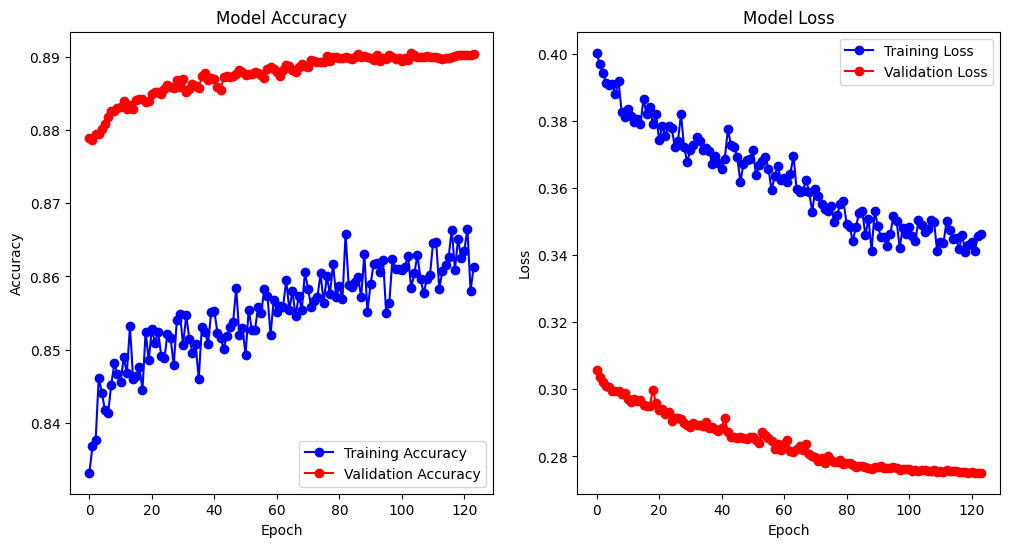

In [15]:
plot_training_history(
    training_history.history['categorical_accuracy'],
    training_history.history['val_categorical_accuracy'],
    training_history.history['loss'],
    training_history.history['val_loss']
                      )

In [16]:
results = pretrained_model.evaluate(test_dataset)
metric_names = pretrained_model.metrics_names  # Get metric names
results_dict = dict(zip(metric_names, results))  # Create a dictionary

print(results_dict)
#print(f"\nFinal Test Accuracy: {test_accuracy:.4f},Final Test Loss: {test_loss:.4f}")

2025-02-06 13:18:13.562264: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1474560000 exceeds 10% of free system memory.


235/235 [==============================] - 2s 5ms/step - loss: 0.2756 - precision: 0.9674 - recall: 0.8479 - categorical_accuracy: 0.8905
{'loss': 0.2755949795246124, 'precision': 0.9674425721168518, 'recall': 0.8478666543960571, 'categorical_accuracy': 0.8905333280563354}


# Model Performance Results

## Initial Model (Old)
- **Validation Metrics**
    - Accuracy: 0.9397
    - Loss: 0.1974
- **Training Metrics**
    - Accuracy: 0.8877
    - Loss: 0.2755
- **Final Test Results**
    - Accuracy: 0.9246
    - Loss: 0.2040

---

## Pretrained Model Retraining
- **Validation Metrics**
    - Accuracy: 0.87
    - Loss: 0.31
- **Training Metrics**
    - Accuracy: 0.84
    - Loss: 0.39
- **Test Results**
    - Loss: 0.3069
    - Precision: 0.9663
    - Recall: 0.8305
    - Categorical Accuracy: 0.8741

---

## Results (05/02/2025)
- **Training Metrics**
    - Accuracy: 0.87
    - Precision: 0.94
    - Recall: 0.83
    - Loss: 0.35
- **Validation Metrics**
    - Accuracy: 0.92
    - Precision: 0.97
    - Recall: 0.89
    - Loss: 0.24
- **Test Results**
    - Loss: 0.2391
    - Precision: 0.9656
    - Recall: 0.8924
    - Categorical Accuracy: 0.9234

## Latest Results (06/02/2025)
- **Training Metrics**
    - Accuracy: 0.85
    - Precision: 0.94
    - Recall: 0.81
    - Loss: 0.36
- **Validation Metrics**
    - Accuracy: 0.90
    - Precision: 0.96
    - Recall: 0.86
    - Loss: 0.27
- **Test Results**
    - Loss: 0.27121
    - Precision: 0.96334
    - Recall: 0.8621
    - Categorical Accuracy: 0.89933

In [17]:
from datetime import datetime
timestamp = datetime.now().strftime("%d_%m_%Y_%HH_%M")

In [18]:
# Check if 'categorical_accuracy' exists and is a float
if 'categorical_accuracy' in results_dict and isinstance(results_dict['categorical_accuracy'], (float, int)):
    model_save_path = f"models/re_trained_{timestamp}_{results_dict['categorical_accuracy']:.3f}.keras"
    print(f"Model will be saved to: {model_save_path}")
else:
    print("Error: 'categorical_accuracy' key is missing or its value is not a float.")

Model will be saved to: models/re_trained_06_02_2025_13H_18_0.891.keras


In [19]:
pretrained_model.save(model_save_path)